In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import KFold, RepeatedKFold, train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV 
warnings.filterwarnings('ignore')

In [2]:
churn=pd.read_excel("Customer Churn Data.xlsx", sheet_name=1)

In [3]:
# List with all missing value formats
missing_value_formats = ["#","&&&&","NA","+", " ", "@","$","*",]
churn = pd.read_excel("Customer Churn Data.xlsx", sheet_name=1, na_values = missing_value_formats)

In [4]:
# Cleaning the data
churn['Gender'].replace(to_replace = 'F', value = 'Female', inplace = True)
churn['Gender'].replace(to_replace = 'M', value = 'Male', inplace = True)
churn['Payment'].replace(to_replace = 'Cash on Delivery', value = 'COD', inplace = True)
churn['account_segment'].replace(to_replace = 'Regular +', value = 'Regular Plus', inplace = True)
churn['account_segment'].replace(to_replace = 'Super +', value = 'Super Plus', inplace = True)

In [5]:
# Geting unique counts of all Nominal Variables
for column in churn[['Payment', 'Gender', 'account_segment', 'Marital_Status', 'Complain_ly', 'Login_device']]:
    print('\n')
    print(column.upper(),': ',churn[column].nunique())
    print(churn[column].value_counts().sort_values())



PAYMENT :  5
UPI             822
COD            1014
E wallet       1217
Credit Card    3511
Debit Card     4587
Name: Payment, dtype: int64


GENDER :  2
Female    4448
Male      6704
Name: Gender, dtype: int64


ACCOUNT_SEGMENT :  5
Regular          520
Super Plus       818
HNI             1639
Super           4062
Regular Plus    4124
Name: account_segment, dtype: int64


MARITAL_STATUS :  3
Divorced    1668
Single      3520
Married     5860
Name: Marital_Status, dtype: int64


COMPLAIN_LY :  2
1.0    3111
0.0    7792
Name: Complain_ly, dtype: int64


LOGIN_DEVICE :  2
Computer    3018
Mobile      7482
Name: Login_device, dtype: int64


In [6]:
X = churn.drop(['Churn'], axis=1)
y = churn['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=123,stratify=churn['Churn'])

churn_train = pd.concat([X_train,y_train], axis=1)
churn_test = pd.concat([X_test,y_test], axis=1)

churn_train.to_csv('churn_train.csv',index=False)
churn_test.to_csv('churn_test.csv',index=False)


In [7]:
#Tenure to categorical column (Grouping the data according to years.)
def Tenure_lab(churn_train) :
    
    if churn_train["Tenure"] <= 12 :
        return "Tenure_0-12"
    elif (churn_train["Tenure"] > 12) & (churn_train["Tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (churn_train["Tenure"] > 24) & (churn_train["Tenure"] <= 48) :
        return "Tenure_24-48"
    elif (churn_train["Tenure"] > 48) & (churn_train["Tenure"] <= 60) :
        return "Tenure_48-60"
    elif churn_train["Tenure"] > 60 :
        return "Tenure_gt_60"
churn_train["Tenure_group"] = churn_train.apply(lambda churn_train:Tenure_lab(churn_train), axis = 1)

# remove the Tenure variables and check the train data for the 10 rows 

churn_train = churn_train.drop(['Tenure'], axis=1)

#Tenure to categorical column
def Tenure_lab(churn_test) :
    
    if churn_test["Tenure"] <= 12 :
        return "Tenure_0-12"
    elif (churn_test["Tenure"] > 12) & (churn_test["Tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (churn_test["Tenure"] > 24) & (churn_test["Tenure"] <= 48) :
        return "Tenure_24-48"
    elif (churn_test["Tenure"] > 48) & (churn_test["Tenure"] <= 60) :
        return "Tenure_48-60"
    elif churn_test["Tenure"] > 60 :
        return "Tenure_gt_60"
churn_test["Tenure_group"] = churn_test.apply(lambda churn_test:Tenure_lab(churn_test), axis = 1)

# remove the Tenure variables and check the Test data for the 10 rows 

churn_test = churn_test.drop(['Tenure'], axis=1)

churn_train.head(10)

,AccountID,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device,Churn,Tenure_group
2095,22095,3.0,34.0,Credit Card,Female,2.0,1.0,Super Plus,1.0,Married,4.0,1.0,18.0,4.0,11.0,233.20,Mobile,0,Tenure_12-24
1875,21875,1.0,6.0,Debit Card,Female,3.0,3.0,HNI,5.0,Married,2.0,0.0,11.0,0.0,7.0,174.12,Mobile,0,Tenure_0-12
9487,29487,3.0,29.0,Credit Card,Male,3.0,6.0,Super,1.0,Married,10.0,1.0,15.0,2.0,3.0,182.40,Mobile,1,Tenure_0-12
5615,25615,1.0,9.0,Debit Card,Male,1.0,5.0,Regular Plus,3.0,Single,4.0,0.0,15.0,1.0,3.0,153.09,Mobile,0,Tenure_12-24
3307,23307,1.0,11.0,Credit Card,Male,3.0,4.0,Super,4.0,Single,11.0,0.0,13.0,2.0,4.0,184.33,Mobile,0,Tenure_12-24
3840,23840,1.0,25.0,Debit Card,Male,3.0,2.0,Super,5.0,Married,3.0,0.0,12.0,1.0,11.0,177.08,Mobile,0,Tenure_0-12
1845,21845,1.0,15.0,Debit Card,Female,3.0,3.0,Super,1.0,Married,2.0,1.0,12.0,1.0,5.0,163.22,Mobile,0,Tenure_0-12
2628,22628,1.0,7.0,Debit Card,Male,2.0,3.0,Regular Plus,1.0,Married,2.0,0.0,11.0,0.0,3.0,120.44,Mobile,0,Tenure_0-12
7249,27249,1.0,12.0,Credit Card,Male,3.0,4.0,Regular Plus,3.0,Single,2.0,0.0,19.0,1.0,0.0,139.30,Mobile,0,Tenure_0-12
11172,31172,1.0,13.0,Credit Card,Male,3.0,4.0,Regular Plus,5.0,Married,6.0,1.0,16.0,3.0,4.0,160.65,Computer,0,Tenure_0-12


In [8]:
# remove the unwanted variables and check the data for the 10 rows 

churn_train = churn_train.drop(['AccountID'], axis=1)
churn_test = churn_test.drop(['AccountID'], axis=1)
churn_train.head(10)

,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device,Churn,Tenure_group
2095,3.0,34.0,Credit Card,Female,2.0,1.0,Super Plus,1.0,Married,4.0,1.0,18.0,4.0,11.0,233.20,Mobile,0,Tenure_12-24
1875,1.0,6.0,Debit Card,Female,3.0,3.0,HNI,5.0,Married,2.0,0.0,11.0,0.0,7.0,174.12,Mobile,0,Tenure_0-12
9487,3.0,29.0,Credit Card,Male,3.0,6.0,Super,1.0,Married,10.0,1.0,15.0,2.0,3.0,182.40,Mobile,1,Tenure_0-12
5615,1.0,9.0,Debit Card,Male,1.0,5.0,Regular Plus,3.0,Single,4.0,0.0,15.0,1.0,3.0,153.09,Mobile,0,Tenure_12-24
3307,1.0,11.0,Credit Card,Male,3.0,4.0,Super,4.0,Single,11.0,0.0,13.0,2.0,4.0,184.33,Mobile,0,Tenure_12-24
3840,1.0,25.0,Debit Card,Male,3.0,2.0,Super,5.0,Married,3.0,0.0,12.0,1.0,11.0,177.08,Mobile,0,Tenure_0-12
1845,1.0,15.0,Debit Card,Female,3.0,3.0,Super,1.0,Married,2.0,1.0,12.0,1.0,5.0,163.22,Mobile,0,Tenure_0-12
2628,1.0,7.0,Debit Card,Male,2.0,3.0,Regular Plus,1.0,Married,2.0,0.0,11.0,0.0,3.0,120.44,Mobile,0,Tenure_0-12
7249,1.0,12.0,Credit Card,Male,3.0,4.0,Regular Plus,3.0,Single,2.0,0.0,19.0,1.0,0.0,139.30,Mobile,0,Tenure_0-12
11172,1.0,13.0,Credit Card,Male,3.0,4.0,Regular Plus,5.0,Married,6.0,1.0,16.0,3.0,4.0,160.65,Computer,0,Tenure_0-12


In [9]:
#After removal of unwanted variables
print(churn_train.shape)
print(churn_test.shape)

(7544, 18)
(3716, 18)


In [10]:
X_train = churn_train.drop(['Churn'], axis=1)
y_train = churn_train['Churn'] 
X_test = churn_test.drop(['Churn'], axis=1)
y_test = churn_test['Churn']

In [11]:
#Checking for Missing values

def missing_check(X_train):
    total = X_train.isnull().sum().sort_values(ascending=False)   # total number of null values
    percent = (X_train.isnull().sum()/X_train.isnull().count()).sort_values(ascending=False)*100  # percentage of values that are null
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])  # putting the above two together
    return missing_data 

# return the dataframe
missing_check(X_train)


,Total,Percent
rev_per_month,522,6.919406
Login_device,506,6.707317
cashback,312,4.135737
Account_user_count,290,3.844115
Complain_ly,239,3.168081
Day_Since_CC_connect,237,3.141569
Tenure_group,144,1.908802
Marital_Status,138,1.829268
CC_Agent_Score,82,1.086957
Gender,72,0.954401


In [12]:
#Checking for Missing values

def missing_check(X_test):
    total = X_test.isnull().sum().sort_values(ascending=False)   # total number of null values
    percent = (X_test.isnull().sum()/X_test.isnull().count()).sort_values(ascending=False)*100  # percentage of values that are null
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])  # putting the above two together
    return missing_data 

# return the dataframe
missing_check(X_test)


,Total,Percent
rev_per_month,269,7.238967
Login_device,254,6.835307
cashback,161,4.332616
Account_user_count,154,4.144241
Day_Since_CC_connect,121,3.256189
Complain_ly,118,3.175457
Tenure_group,74,1.991389
Marital_Status,74,1.991389
City_Tier,49,1.318622
CC_Contacted_LY,41,1.103337


In [13]:
#Train
for column in X_train[['Payment','Gender','account_segment','Marital_Status','Complain_ly','Login_device','Tenure_group']]:
    X_train[column].fillna(X_train[column].mode()[0], inplace=True)
#Test   
for column in X_test[['Payment','Gender','account_segment','Marital_Status','Complain_ly','Login_device','Tenure_group']]:
    X_test[column].fillna(X_train[column].mode()[0], inplace=True)

In [14]:
#Train
# Converting Object data type into Categorical

for feature in X_train.columns: 
    if X_train[feature].dtype == 'object': 
        print('\n')
        print('feature:',feature)
        print(pd.Categorical(X_train[feature].unique()))
        print(pd.Categorical(X_train[feature].unique()).codes)
        X_train[feature] = pd.Categorical(X_train[feature]).codes
        



feature: Payment
['Credit Card', 'Debit Card', 'E wallet', 'UPI', 'COD']
Categories (5, object): ['COD', 'Credit Card', 'Debit Card', 'E wallet', 'UPI']
[1 2 3 4 0]


feature: Gender
['Female', 'Male']
Categories (2, object): ['Female', 'Male']
[0 1]


feature: account_segment
['Super Plus', 'HNI', 'Super', 'Regular Plus', 'Regular']
Categories (5, object): ['HNI', 'Regular', 'Regular Plus', 'Super', 'Super Plus']
[4 0 3 2 1]


feature: Marital_Status
['Married', 'Single', 'Divorced']
Categories (3, object): ['Divorced', 'Married', 'Single']
[1 2 0]


feature: Login_device
['Mobile', 'Computer']
Categories (2, object): ['Computer', 'Mobile']
[1 0]


feature: Tenure_group
['Tenure_12-24', 'Tenure_0-12', 'Tenure_24-48', 'Tenure_gt_60', 'Tenure_48-60']
Categories (5, object): ['Tenure_0-12', 'Tenure_12-24', 'Tenure_24-48', 'Tenure_48-60', 'Tenure_gt_60']
[1 0 2 4 3]


In [15]:
#Test
# Converting Object data type into Categorical

for feature in X_test.columns: 
    if X_test[feature].dtype == 'object': 
        print('\n')
        print('feature:',feature)
        print(pd.Categorical(X_test[feature].unique()))
        print(pd.Categorical(X_test[feature].unique()).codes)
        X_test[feature] = pd.Categorical(X_test[feature]).codes




feature: Payment
['Credit Card', 'Debit Card', 'COD', 'E wallet', 'UPI']
Categories (5, object): ['COD', 'Credit Card', 'Debit Card', 'E wallet', 'UPI']
[1 2 0 3 4]


feature: Gender
['Female', 'Male']
Categories (2, object): ['Female', 'Male']
[0 1]


feature: account_segment
['Super', 'Regular Plus', 'HNI', 'Super Plus', 'Regular']
Categories (5, object): ['HNI', 'Regular', 'Regular Plus', 'Super', 'Super Plus']
[3 2 0 4 1]


feature: Marital_Status
['Single', 'Married', 'Divorced']
Categories (3, object): ['Divorced', 'Married', 'Single']
[2 1 0]


feature: Login_device
['Mobile', 'Computer']
Categories (2, object): ['Computer', 'Mobile']
[1 0]


feature: Tenure_group
['Tenure_0-12', 'Tenure_12-24', 'Tenure_24-48', 'Tenure_gt_60', 'Tenure_48-60']
Categories (5, object): ['Tenure_0-12', 'Tenure_12-24', 'Tenure_24-48', 'Tenure_48-60', 'Tenure_gt_60']
[0 1 2 4 3]


In [16]:
col_names = ['City_Tier','CC_Contacted_LY','Payment','Gender','Service_Score','Account_user_count','account_segment',
             'CC_Agent_Score','Marital_Status','rev_per_month','Complain_ly','rev_growth_yoy','coupon_used_for_payment',
             'Day_Since_CC_connect','cashback','Login_device','Tenure_group']    
    
from sklearn.impute import KNNImputer
knn=KNNImputer(n_neighbors=5)

# Fitting the data to the imputer object
imputer = knn.fit(X_train)

# Imputing the train data
X_train = pd.DataFrame(imputer.transform(X_train))
X_train.columns=col_names

# Imputing the median data in test data
X_test = pd.DataFrame(imputer.transform(X_test))
X_test.columns=col_names

X_train.head()

,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device,Tenure_group
0,3.0,34.0,1.0,0.0,2.0,1.0,4.0,1.0,1.0,4.0,1.0,18.0,4.0,11.0,233.20,1.0,1.0
1,1.0,6.0,2.0,0.0,3.0,3.0,0.0,5.0,1.0,2.0,0.0,11.0,0.0,7.0,174.12,1.0,0.0
2,3.0,29.0,1.0,1.0,3.0,6.0,3.0,1.0,1.0,10.0,1.0,15.0,2.0,3.0,182.40,1.0,0.0
3,1.0,9.0,2.0,1.0,1.0,5.0,2.0,3.0,2.0,4.0,0.0,15.0,1.0,3.0,153.09,1.0,1.0
4,1.0,11.0,1.0,1.0,3.0,4.0,3.0,4.0,2.0,11.0,0.0,13.0,2.0,4.0,184.33,1.0,1.0


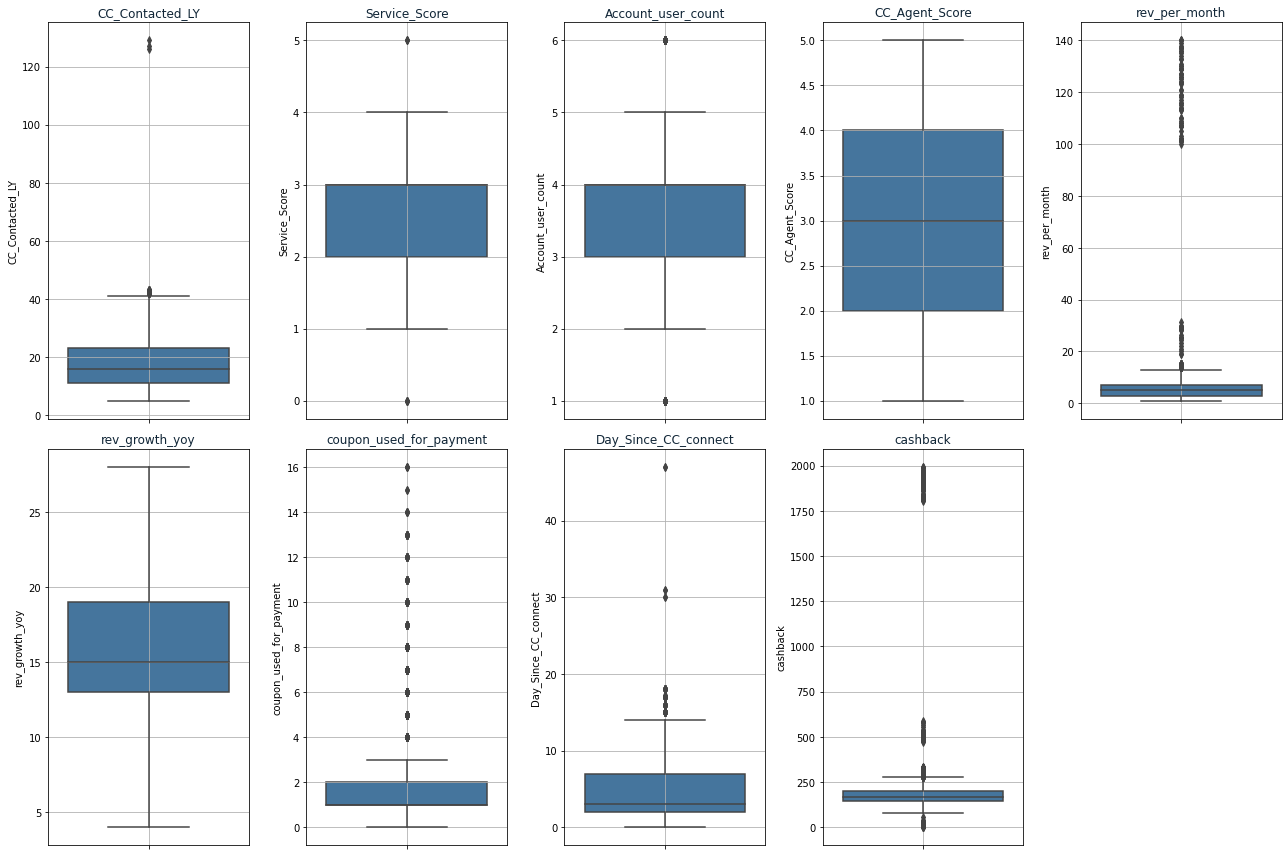

In [17]:
#For Train Data:
continuous = ['CC_Contacted_LY','Service_Score','Account_user_count',
             'CC_Agent_Score','rev_per_month','rev_growth_yoy','coupon_used_for_payment',
             'Day_Since_CC_connect','cashback']    

data_plot=X_train[continuous]

fig=plt.figure(figsize=(18,12))

for i in range(0,len(data_plot.columns)):
    ax=fig.add_subplot(2,5,i+1)
    sns.boxplot(y=data_plot[data_plot.columns[i]],color='#3776ab')
    ax.set_title(data_plot.columns[i],color='#112637')
    plt.grid()

    plt.tight_layout()


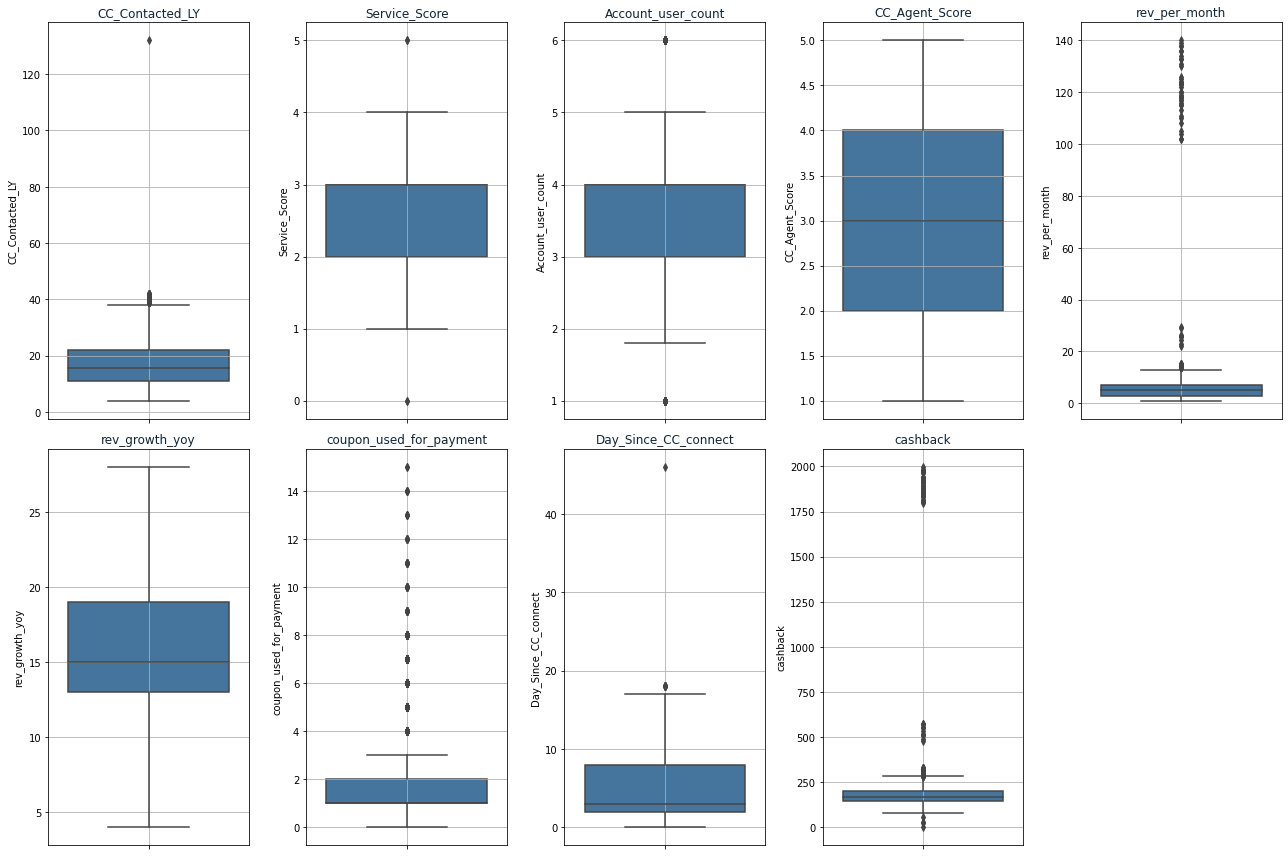

In [18]:
#For Test Data:
data_plot=X_test[continuous]

fig=plt.figure(figsize=(18,12))

for i in range(0,len(data_plot.columns)):
    ax=fig.add_subplot(2,5,i+1)
    sns.boxplot(y=data_plot[data_plot.columns[i]],color='#3776ab')
    ax.set_title(data_plot.columns[i],color='#112637')
    plt.grid()

    plt.tight_layout()

In [19]:
#Capping the outliers

def treat_outlier(x):
    
    # taking 5,25,75 percentile of column
    q5= np.percentile(x,5)
    q25=np.percentile(x,25)
    q75=np.percentile(x,75)
    dt=np.percentile(x,95)
    
    #calculationg IQR range
    IQR=q75-q25
    
    #Calculating minimum threshold
    lower_bound=q25-(1.5*IQR)
    upper_bound=q75+(1.5*IQR)
    
    #Calculating maximum threshold
    print(q5,q25,q75,dt,min,max)
    
    #Capping outliers
    return x.apply(lambda y: dt if y > upper_bound else y).apply(lambda y: q5 if y < lower_bound else y)

In [20]:
for i in X_train:
    X_train[i]=treat_outlier(X_train[i])

1.0 1.0 3.0 3.0 <built-in function min> <built-in function max>
7.0 11.0 23.0 35.0 <built-in function min> <built-in function max>
0.0 1.0 2.0 4.0 <built-in function min> <built-in function max>
0.0 0.0 1.0 1.0 <built-in function min> <built-in function max>
2.0 2.0 3.0 4.0 <built-in function min> <built-in function max>
2.0 3.0 4.0 5.0 <built-in function min> <built-in function max>
0.0 2.0 3.0 4.0 <built-in function min> <built-in function max>
1.0 2.0 4.0 5.0 <built-in function min> <built-in function max>
0.0 1.0 2.0 2.0 <built-in function min> <built-in function max>
2.0 3.0 7.0 11.0 <built-in function min> <built-in function max>
0.0 0.0 1.0 1.0 <built-in function min> <built-in function max>
12.0 13.0 19.0 24.0 <built-in function min> <built-in function max>
0.0 1.0 2.0 6.0 <built-in function min> <built-in function max>
0.0 2.0 7.0 11.0 <built-in function min> <built-in function max>
124.3615 147.07 199.6275 296.87799999999993 <built-in function min> <built-in function max>
0.0

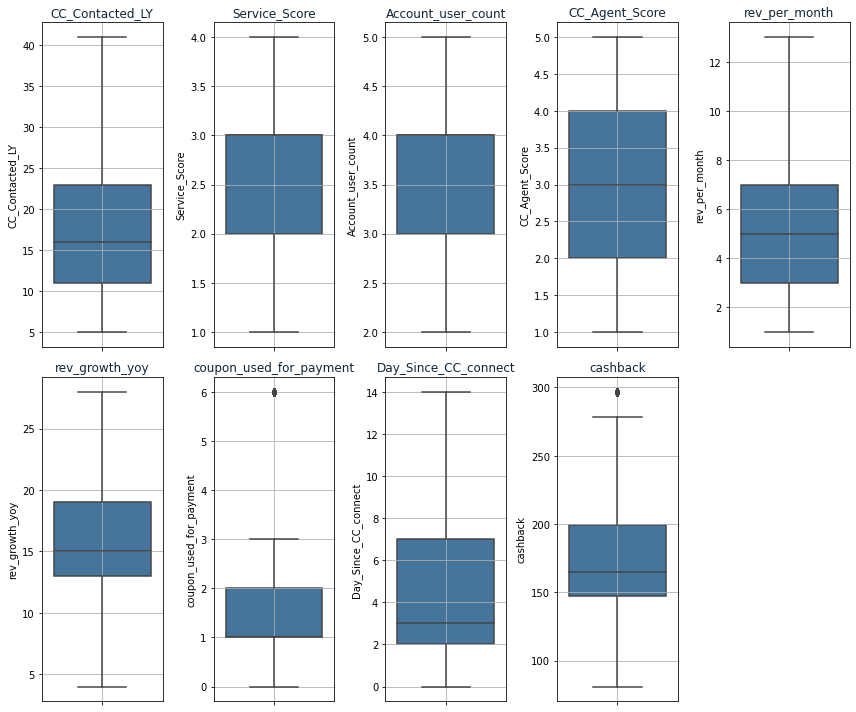

In [21]:
#For Train Data:
data_plot=X_train[continuous]

fig=plt.figure(figsize=(12,10))

for i in range(0,len(data_plot.columns)):
    ax=fig.add_subplot(2,5,i+1)
    sns.boxplot(y=data_plot[data_plot.columns[i]],color='#3776ab')
    ax.set_title(data_plot.columns[i],color='#112637')
    plt.grid()

    plt.tight_layout()

In [22]:
for i in X_train:
    X_test[i]=treat_outlier(X_test[i])

1.0 1.0 3.0 3.0 <built-in function min> <built-in function max>
7.0 11.0 22.0 35.0 <built-in function min> <built-in function max>
0.0 1.0 2.0 4.0 <built-in function min> <built-in function max>
0.0 0.0 1.0 1.0 <built-in function min> <built-in function max>
2.0 2.0 3.0 4.0 <built-in function min> <built-in function max>
2.0 3.0 4.0 5.0 <built-in function min> <built-in function max>
0.0 2.0 3.0 4.0 <built-in function min> <built-in function max>
1.0 2.0 4.0 5.0 <built-in function min> <built-in function max>
0.0 1.0 2.0 2.0 <built-in function min> <built-in function max>
2.0 3.0 7.0 11.0 <built-in function min> <built-in function max>
0.0 0.0 1.0 1.0 <built-in function min> <built-in function max>
11.0 13.0 19.0 23.0 <built-in function min> <built-in function max>
0.0 1.0 2.0 6.0 <built-in function min> <built-in function max>
0.0 2.0 8.0 11.0 <built-in function min> <built-in function max>
124.2025 147.73450000000003 202.0925 297.16499999999996 <built-in function min> <built-in funct

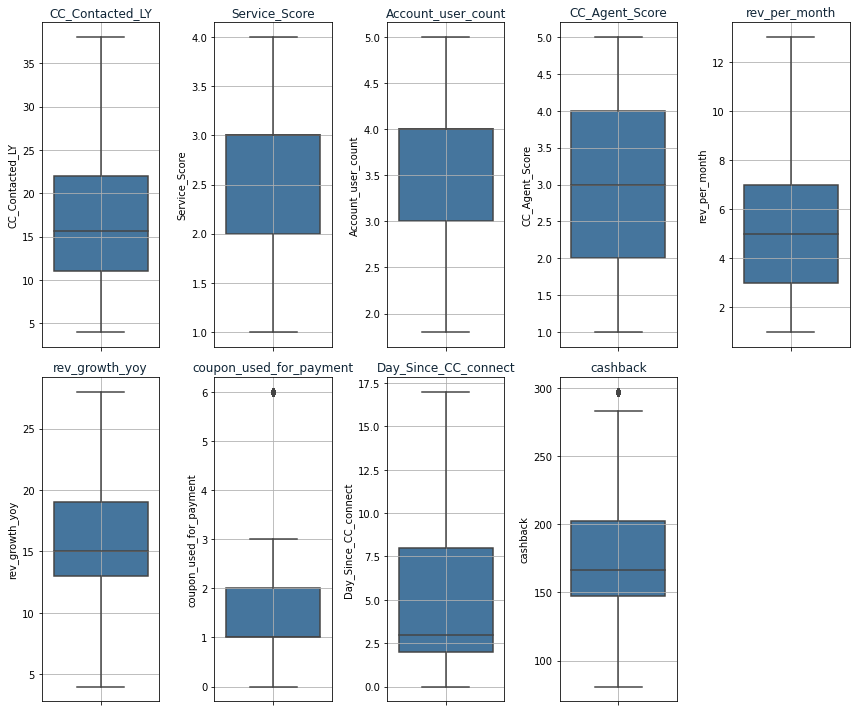

In [23]:
#For Test Data:
data_plot=X_test[continuous]

fig=plt.figure(figsize=(12,10))

for i in range(0,len(data_plot.columns)):
    ax=fig.add_subplot(2,5,i+1)
    sns.boxplot(y=data_plot[data_plot.columns[i]],color='#3776ab')
    ax.set_title(data_plot.columns[i],color='#112637')
    plt.grid()

    plt.tight_layout()

### Mutual information-based feature selection 

In [24]:
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

array([0.00012163, 0.00257675, 0.00331703, 0.        , 0.00845492,
       0.000757  , 0.01784169, 0.00569796, 0.02328383, 0.00379151,
       0.03183893, 0.        , 0.        , 0.01816382, 0.05336638,
       0.00431137, 0.03047588])

In [25]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

cashback                   0.053366
Complain_ly                0.031839
Tenure_group               0.030476
Marital_Status             0.023284
Day_Since_CC_connect       0.018164
account_segment            0.017842
Service_Score              0.008455
CC_Agent_Score             0.005698
Login_device               0.004311
rev_per_month              0.003792
Payment                    0.003317
CC_Contacted_LY            0.002577
Account_user_count         0.000757
City_Tier                  0.000122
coupon_used_for_payment    0.000000
rev_growth_yoy             0.000000
Gender                     0.000000
dtype: float64

<AxesSubplot:>

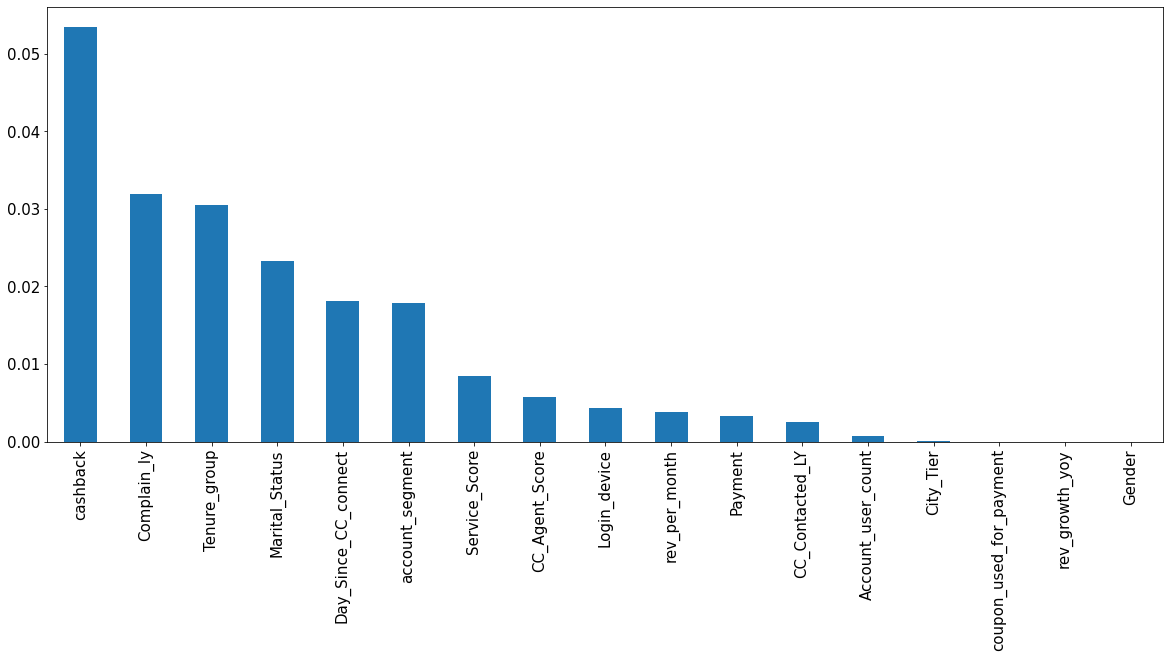

In [26]:
#let's plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8),fontsize = 15)

In [27]:
from sklearn.feature_selection import SelectKBest

In [28]:
#Now we will select the  top 8 important features
fs = SelectKBest(mutual_info_classif, k=8)

# learn relationship from training data
fs.fit(X_train, y_train)
X_train.columns[fs.get_support()] 

Index(['Account_user_count', 'account_segment', 'Marital_Status',
       'Complain_ly', 'Day_Since_CC_connect', 'cashback', 'Login_device',
       'Tenure_group'],
      dtype='object')

In [29]:
# transform train input data
X_train_fs = fs.transform(X_train)

# transform test input data
X_test_fs = fs.transform(X_test)

print(X_train.columns[fs.get_support()])
print(X_test.columns[fs.get_support()])


Index(['Account_user_count', 'account_segment', 'Marital_Status',
       'Complain_ly', 'Day_Since_CC_connect', 'cashback', 'Login_device',
       'Tenure_group'],
      dtype='object')
Index(['Account_user_count', 'account_segment', 'Marital_Status',
       'Complain_ly', 'Day_Since_CC_connect', 'cashback', 'Login_device',
       'Tenure_group'],
      dtype='object')


In [30]:
X_train_fs

array([[  2.  ,   4.  ,   1.  , ..., 233.2 ,   1.  ,   1.  ],
       [  3.  ,   0.  ,   1.  , ..., 174.12,   1.  ,   0.  ],
       [  5.  ,   3.  ,   1.  , ..., 182.4 ,   1.  ,   0.  ],
       ...,
       [  4.  ,   3.  ,   2.  , ..., 173.09,   1.  ,   0.  ],
       [  4.  ,   3.  ,   2.  , ..., 153.43,   0.  ,   0.  ],
       [  4.  ,   2.  ,   1.  , ..., 138.  ,   0.  ,   0.  ]])

In [31]:
X_train_fs = pd.DataFrame(X_train_fs, columns = X_train.columns[fs.get_support()])
X_train_fs

,Account_user_count,account_segment,Marital_Status,Complain_ly,Day_Since_CC_connect,cashback,Login_device,Tenure_group
0,2.0,4.0,1.0,1.0,11.0,233.200,1.0,1.0
1,3.0,0.0,1.0,0.0,7.0,174.120,1.0,0.0
2,5.0,3.0,1.0,1.0,3.0,182.400,1.0,0.0
3,5.0,2.0,2.0,0.0,3.0,153.090,1.0,1.0
4,4.0,3.0,2.0,0.0,4.0,184.330,1.0,1.0
...,...,...,...,...,...,...,...,...
7539,3.0,1.0,1.0,0.0,2.0,296.878,1.0,2.0
7540,4.0,2.0,2.0,1.0,0.0,138.460,0.0,0.0
7541,4.0,3.0,2.0,0.0,11.0,173.090,1.0,0.0
7542,4.0,3.0,2.0,0.0,9.0,153.430,0.0,0.0


In [32]:
X_test_fs = pd.DataFrame(X_test_fs, columns = X_test.columns[fs.get_support()])
X_test_fs

,Account_user_count,account_segment,Marital_Status,Complain_ly,Day_Since_CC_connect,cashback,Login_device,Tenure_group
0,4.0,3.0,2.0,1.0,5.0,160.958,1.0,0.0
1,4.0,2.0,2.0,0.0,1.0,157.420,1.0,0.0
2,2.0,3.0,1.0,0.0,7.0,154.540,1.0,1.0
3,4.0,2.0,1.0,0.0,3.0,139.550,1.0,0.0
4,5.0,2.0,1.0,0.0,3.0,147.690,1.0,0.0
...,...,...,...,...,...,...,...,...
3711,2.0,4.0,0.0,0.0,3.0,218.464,1.0,2.0
3712,3.0,2.0,1.0,1.0,2.0,125.730,1.0,0.0
3713,2.0,2.0,2.0,0.0,2.0,121.090,1.0,0.0
3714,4.0,2.0,2.0,0.0,2.0,130.330,1.0,0.0


### Feature Scaling - Standardization:

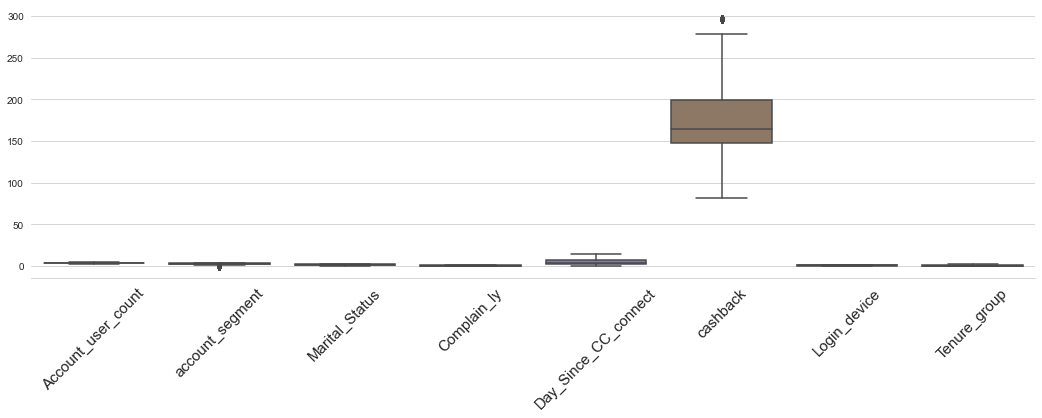

In [33]:
# Before scaling

fig=plt.figure(figsize=(18,5))

sns.set_style("whitegrid")
sns.boxplot(data=X_train_fs,  palette="deep")
plt.xticks(rotation=45, fontsize = 15)
sns.despine(left=True)

In [43]:
# data standardization with  sklearn
from sklearn.preprocessing import StandardScaler

# copy of datasets
X_train_scaled = X_train_fs.copy()
X_test_scaled = X_test_fs.copy()

# numerical features
num_cols = ['Day_Since_CC_connect','cashback']

# apply standardization on numerical features
for i in num_cols:
    
    # fit on training data column
    scale = StandardScaler().fit(X_train_scaled[[i]])
    
    # transform the training data column
    X_train_scaled[i] = scale.transform(X_train_scaled[[i]])
    
    # transform the testing data column
    X_test_scaled[i] = scale.transform(X_test_scaled[[i]])

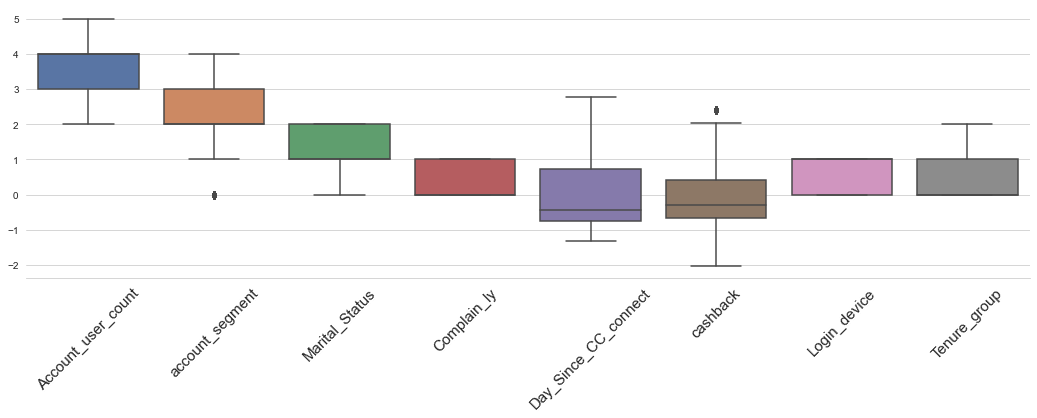

In [44]:
# After scaling Train data

fig=plt.figure(figsize=(18,5))

sns.set_style("whitegrid")
sns.boxplot(data=X_train_scaled,  palette="deep")
plt.xticks(rotation=45, fontsize = 15)
sns.despine(left=True)

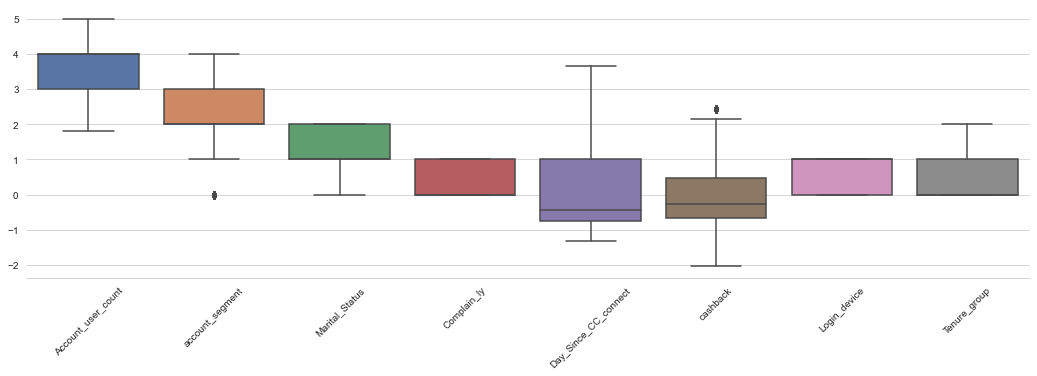

In [45]:
# After scaling Test data

fig=plt.figure(figsize=(18,5))

sns.set_style("whitegrid")
sns.boxplot(data=X_test_scaled,  palette="deep")
plt.xticks(rotation=45)
sns.despine(left=True)

### Model Building - Imbalanced data

In [46]:
model = list()
dataset = list()
resample = list()
precision = list()
recall = list()
F1score = list()
Accuracy = list()
AUCROC = list()

In [47]:
sns.set(font_scale=1.5)

def train_eval(clf_model, X_train_scaled, y_train, algo=None, sampling=None):
    
    # Test set prediction
    y_prob=clf_model.predict_proba(X_train_scaled)
    y_pred=clf_model.predict(X_train_scaled)

    print('Classification Report for Train dataset')
    print('='*60)
    print(classification_report(y_train,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_train, y_prob[:,1]),"\n")
    
    print('Confusion Matrix')
    print('='*60)
    cf_matrix = confusion_matrix(y_train, y_pred)
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
          
    model.append(algo)
    precision.append(precision_score(y_train,y_pred))
    recall.append(recall_score(y_train,y_pred))
    F1score.append(f1_score(y_train,y_pred))
    Accuracy.append(accuracy_score(y_train, y_pred))
    AUCROC.append(roc_auc_score(y_train, y_prob[:,1]))
    dataset.append('train')
    resample.append(sampling)
   

In [48]:
def test_eval(clf_model, X_test_scaled, y_test, algo=None, sampling=None):
    
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test_scaled)
    y_pred=clf_model.predict(X_test_scaled)

    print('Classification Report for Test dataset')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_test, y_prob[:,1]),"\n")
    
    print('Confusion Matrix')
    print('='*60)
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
          
    model.append(algo)
    precision.append(precision_score(y_test,y_pred))
    recall.append(recall_score(y_test,y_pred))
    F1score.append(f1_score(y_test,y_pred))
    Accuracy.append(accuracy_score(y_test, y_pred))
    AUCROC.append(roc_auc_score(y_test, y_prob[:,1]))
    dataset.append('test')
    resample.append(sampling)

### Model-1: Logistic Regression

In [49]:
# copy of datasets
X_train_sc = X_train_scaled.copy()
X_test_sc = X_test_scaled.copy()

In [50]:
from sklearn.linear_model import LogisticRegression

In [51]:
log_model=LogisticRegression()

params={'C':np.logspace(1,5, num=5),'class_weight':[None,'balanced'],'penalty':['l1','l2']}

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

# Create grid search using 5-fold cross validation
clf_LR = RandomizedSearchCV(log_model, params, cv=cv, scoring='recall', n_jobs=-1)
clf_LR.fit(X_train_sc, y_train)
clf_LR.best_estimator_

#clf_LR = LogisticRegression(C=10, class_weight='balanced')
#clf_LR.fit(X_train_scaled, y_train)

LogisticRegression(C=10.0, class_weight='balanced')

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.93      0.71      0.80      6274
           1       0.34      0.74      0.47      1270

    accuracy                           0.71      7544
   macro avg       0.64      0.72      0.63      7544
weighted avg       0.83      0.71      0.75      7544
 

AUC-ROC
0.7930527561565165 

Confusion Matrix


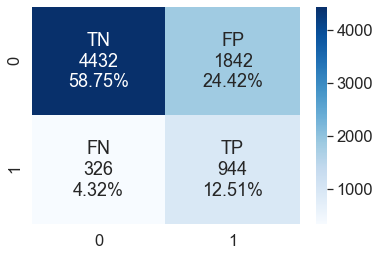

In [52]:
#Train:
train_eval(clf_LR, X_train_sc, y_train, 'Logistic Regression', 'actual')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.94      0.73      0.82      3090
           1       0.36      0.76      0.49       626

    accuracy                           0.73      3716
   macro avg       0.65      0.74      0.65      3716
weighted avg       0.84      0.73      0.76      3716
 

AUC-ROC
0.8086145662086293 

Confusion Matrix


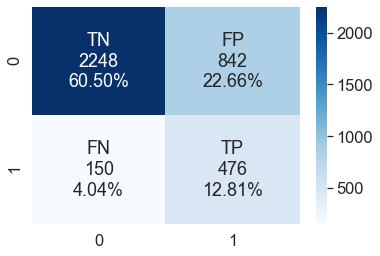

In [53]:
#Test:
test_eval(clf_LR, X_test_sc, y_test, 'Logistic Regression', 'actual')

In [54]:
y_pred = clf_LR.predict(X_train_sc)
Accuracy_Train =  accuracy_score(y_train, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_LR.predict(X_test_sc)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)


Accuracy_Train 0.7126193001060446
Accuracy_Test 0.7330462863293864


### Model-2: Naïve Bayes

In [55]:
# copy of datasets
X_train_sc = X_train_scaled.copy()
X_test_sc = X_test_scaled.copy()

In [56]:
from sklearn.naive_bayes import GaussianNB

clf_nb=GaussianNB()
clf_nb.fit(X_train_sc, y_train)

GaussianNB()

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      6274
           1       0.50      0.48      0.49      1270

    accuracy                           0.83      7544
   macro avg       0.70      0.69      0.69      7544
weighted avg       0.83      0.83      0.83      7544
 

AUC-ROC
0.7740609916189549 

Confusion Matrix


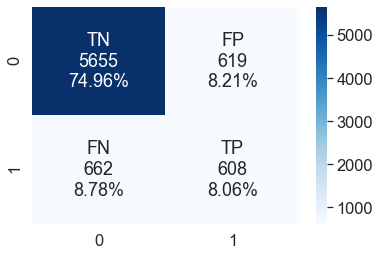

In [57]:
#Train:
train_eval(clf_nb, X_train_sc, y_train, 'Naive Bayes', 'actual')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      3090
           1       0.51      0.49      0.50       626

    accuracy                           0.84      3716
   macro avg       0.70      0.70      0.70      3716
weighted avg       0.83      0.84      0.83      3716
 

AUC-ROC
0.7881574593918339 

Confusion Matrix


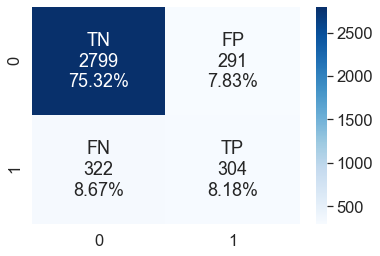

In [58]:
#Test:
test_eval(clf_nb, X_test_sc, y_test, 'Naive Bayes', 'actual')

In [59]:
y_pred = clf_nb.predict(X_train_sc)
Accuracy_Train =  accuracy_score(y_train, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_nb.predict(X_test_sc)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)

Accuracy_Train 0.8301961823966065
Accuracy_Test 0.8350376749192681


### Model-3: Stochastic Gradient Descent

In [60]:
# copy of datasets
X_train_sc = X_train_scaled.copy()
X_test_sc = X_test_scaled.copy()

In [61]:
from sklearn.linear_model import SGDClassifier

clf_sgd = SGDClassifier(loss='log', shuffle=True, max_iter=1500, random_state=123)
clf_sgd.fit(X_train_sc, y_train)

SGDClassifier(loss='log', max_iter=1500, random_state=123)

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      6274
           1       0.52      0.42      0.47      1270

    accuracy                           0.84      7544
   macro avg       0.71      0.67      0.69      7544
weighted avg       0.83      0.84      0.83      7544
 

AUC-ROC
0.787979324747301 

Confusion Matrix


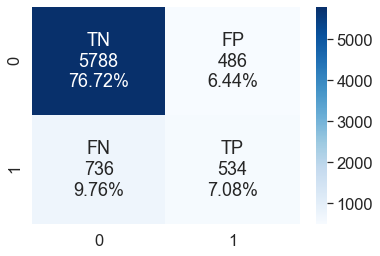

In [62]:
#Train:
train_eval(clf_sgd, X_train_sc, y_train, 'Stochastic Gradient Descent', 'actual')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      3090
           1       0.52      0.43      0.47       626

    accuracy                           0.84      3716
   macro avg       0.70      0.67      0.68      3716
weighted avg       0.83      0.84      0.83      3716
 

AUC-ROC
0.8047574366450573 

Confusion Matrix


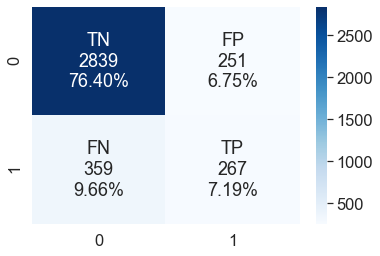

In [63]:
#Test:
test_eval(clf_sgd, X_test_sc, y_test, 'Stochastic Gradient Descent', 'actual')

In [64]:
y_pred = clf_sgd.predict(X_train_sc)
Accuracy_Train =  accuracy_score(y_train, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_sgd.predict(X_test_sc)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)


Accuracy_Train 0.838016967126193
Accuracy_Test 0.8358449946178687


### Model-4: K-Nearest Neighbours

In [65]:
# copy of datasets
X_train_sc = X_train_scaled.copy()
X_test_sc = X_test_scaled.copy()

In [66]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(n_neighbors = 5)
clf_knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      6274
           1       0.81      0.63      0.71      1270

    accuracy                           0.91      7544
   macro avg       0.87      0.80      0.83      7544
weighted avg       0.91      0.91      0.91      7544
 

AUC-ROC
0.9581006729434561 

Confusion Matrix


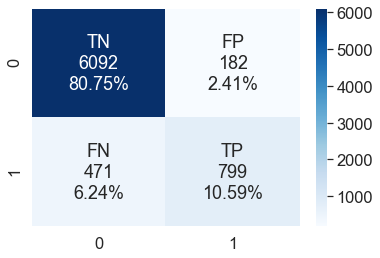

In [67]:
#Train:
train_eval(clf_knn, X_train_sc, y_train, 'K-Nearest Neighbours', 'actual')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      3090
           1       0.64      0.46      0.53       626

    accuracy                           0.87      3716
   macro avg       0.77      0.70      0.73      3716
weighted avg       0.85      0.87      0.86      3716
 

AUC-ROC
0.8571872059720629 

Confusion Matrix


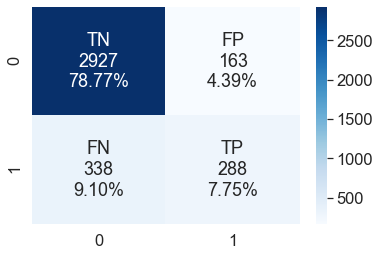

In [68]:
#Test:
test_eval(clf_knn, X_test_sc, y_test, 'K-Nearest Neighbours', 'actual')

In [69]:
y_pred = clf_knn.predict(X_train_sc)
Accuracy_Train =  accuracy_score(y_train, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_knn.predict(X_test_sc)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)


Accuracy_Train 0.913441145281018
Accuracy_Test 0.8651776103336921


### Model-5: Decision Tree

In [70]:
# copy of datasets
X_train_sc = X_train_scaled.copy()
X_test_sc = X_test_scaled.copy()

In [71]:
from sklearn.tree import DecisionTreeClassifier

#Number of trees in random forest
estimators = [30,50,100,300,500]

# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']

# Maximum number of depth in each tree:
max_depth = [i for i in range(5,25,2)]

# Minimum number of samples to consider to split a node:
min_samples_split = [2, 5, 10, 15, 20, 50, 100]

# Minimum number of samples to consider at each leaf node:
min_samples_leaf = [5, 4, 7]

In [72]:
tree_model = DecisionTreeClassifier()

tree_param_grid = {'max_depth': max_depth,
                   'max_features':max_features,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

clf_DT = RandomizedSearchCV(tree_model, tree_param_grid, cv=cv, scoring='recall', random_state=123, n_jobs=-1, verbose=2)
clf_DT.fit(X_train_sc, y_train)
clf_DT.best_estimator_


Fitting 5 folds for each of 10 candidates, totalling 50 fits


DecisionTreeClassifier(max_depth=15, max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=10)

In [73]:
clf_DT = clf_DT.best_estimator_

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      6274
           1       0.77      0.49      0.60      1270

    accuracy                           0.89      7544
   macro avg       0.84      0.73      0.77      7544
weighted avg       0.88      0.89      0.88      7544
 

AUC-ROC
0.9326713294963089 

Confusion Matrix


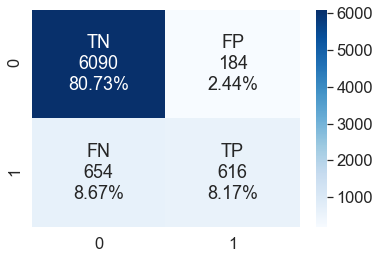

In [74]:
#Train: 
train_eval(clf_DT, X_train_sc, y_train, 'Decision Tree', 'actual')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      3090
           1       0.62      0.35      0.45       626

    accuracy                           0.85      3716
   macro avg       0.75      0.65      0.68      3716
weighted avg       0.84      0.85      0.84      3716
 

AUC-ROC
0.8304936050539202 

Confusion Matrix


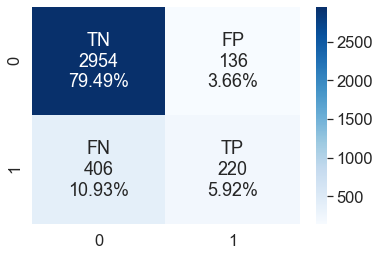

In [75]:
#Test:
test_eval(clf_DT, X_test_sc, y_test, 'Decision Tree', 'actual')

In [76]:
y_pred = clf_DT.predict(X_train_sc)
Accuracy_Train =  accuracy_score(y_train, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_DT.predict(X_test_sc)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)


Accuracy_Train 0.8889183457051962
Accuracy_Test 0.8541442411194833


### Model-6: Random Forest

In [77]:
# copy of datasets
X_train_sc = X_train_scaled.copy()
X_test_sc = X_test_scaled.copy()

In [78]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()

rf_params={'n_estimators':estimators,
           'max_features':max_features,
           'max_depth':max_depth,
           'min_samples_leaf': min_samples_leaf,
           'min_samples_split':min_samples_split}

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

clf_RF = RandomizedSearchCV(rf_model, rf_params, cv=cv, scoring='recall', n_jobs=-1, random_state=123, n_iter=20, verbose=2)
clf_RF.fit(X_train_sc, y_train)
clf_RF.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomForestClassifier(max_depth=23, max_features='log2', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=500)

In [79]:
clf_RF = clf_RF.best_estimator_

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      6274
           1       0.91      0.55      0.68      1270

    accuracy                           0.91      7544
   macro avg       0.91      0.77      0.82      7544
weighted avg       0.91      0.91      0.91      7544
 

AUC-ROC
0.9733792630001581 

Confusion Matrix


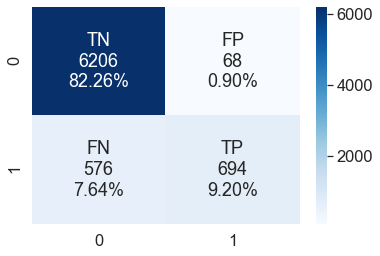

In [80]:
#Train:
train_eval(clf_RF, X_train_sc, y_train, 'Random Forest', 'actual')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      3090
           1       0.75      0.41      0.53       626

    accuracy                           0.88      3716
   macro avg       0.82      0.69      0.73      3716
weighted avg       0.87      0.88      0.86      3716
 

AUC-ROC
0.8998392216466599 

Confusion Matrix


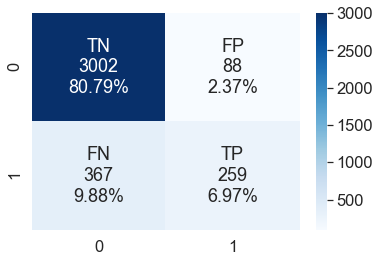

In [81]:
#Test:
test_eval(clf_RF, X_test_sc, y_test, 'Random Forest', 'actual')

In [82]:
y_pred = clf_RF.predict(X_train_sc)
Accuracy_Train =  accuracy_score(y_train, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_RF.predict(X_test_sc)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)

Accuracy_Train 0.9146341463414634
Accuracy_Test 0.8775565123789021


### Model Comparision for imbalanced data

In [83]:
clf_eval_df = pd.DataFrame({'Model':model,
                            'Dataset':dataset,
                            'Resample':resample,
                            'Precision':precision,
                            'Recall':recall,
                            'f1-score':F1score,
                            'Accuracy':Accuracy,
                            'AUC-ROC':AUCROC})

In [84]:
cm = sns.light_palette("green", as_cmap = True)
s = clf_eval_df.style.background_gradient(cmap=cm)
s

,Model,Dataset,Resample,Precision,Recall,f1-score,Accuracy,AUC-ROC
0,Logistic Regression,train,actual,0.338837,0.743307,0.465483,0.712619,0.793053
1,Logistic Regression,test,actual,0.361153,0.760383,0.489712,0.733046,0.808615
2,Naive Bayes,train,actual,0.495518,0.478740,0.486984,0.830196,0.774061
3,Naive Bayes,test,actual,0.510924,0.485623,0.497952,0.835038,0.788157
4,Stochastic Gradient Descent,train,actual,0.523529,0.420472,0.466376,0.838017,0.787979
5,Stochastic Gradient Descent,test,actual,0.515444,0.426518,0.466783,0.835845,0.804757
6,K-Nearest Neighbours,train,actual,0.814475,0.629134,0.709907,0.913441,0.958101
7,K-Nearest Neighbours,test,actual,0.638581,0.460064,0.534819,0.865178,0.857187
8,Decision Tree,train,actual,0.770000,0.485039,0.595169,0.888918,0.932671
9,Decision Tree,test,actual,0.617978,0.351438,0.448065,0.854144,0.830494


### SMOTE:

In [85]:
from imblearn.over_sampling import SMOTE
from collections import Counter

counter = Counter(y_train)
print('Before',counter)

# Oversampling the train dataset using SMOTE
smt = SMOTE(random_state = 123)

#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_smote, y_train_smote = smt.fit_resample(X_train_scaled, y_train.ravel())

counter = Counter(y_train_smote)
print('After',counter)

print('\nAfter OverSampling, the shape of X_train: {}'.format(X_train_smote.shape))
print('After OverSampling, the shape of y_train: {} \n'.format(y_train_smote.shape))

Before Counter({0: 6274, 1: 1270})
After Counter({0: 6274, 1: 6274})

After OverSampling, the shape of X_train: (12548, 8)
After OverSampling, the shape of y_train: (12548,) 



In [86]:
model = list()
dataset = list()
resample = list()
precision = list()
recall = list()
F1score = list()
Accuracy = list()
AUCROC = list()

In [87]:
def train_eval(clf_model, X_train_sm, y_train_sm, algo=None, sampling=None):
    
    # Test set prediction
    y_prob=clf_model.predict_proba(X_train_sm)
    y_pred=clf_model.predict(X_train_sm)

    print('Classification Report for Train dataset')
    print('='*60)
    print(classification_report(y_train_sm,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_train_sm, y_prob[:,1]),"\n")
    
    print('Confusion Matrix')
    print('='*60)
    cf_matrix = confusion_matrix(y_train_sm, y_pred)
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
          
    model.append(algo)
    precision.append(precision_score(y_train_sm,y_pred))
    recall.append(recall_score(y_train_sm,y_pred))
    F1score.append(f1_score(y_train_sm,y_pred))
    Accuracy.append(accuracy_score(y_train_sm, y_pred))
    AUCROC.append(roc_auc_score(y_train_sm, y_prob[:,1]))
    dataset.append('train')
    resample.append(sampling)
   

In [88]:
def test_eval(clf_model, X_test_scaled, y_test, algo=None, sampling=None):
    
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test_scaled)
    y_pred=clf_model.predict(X_test_scaled)

    print('Classification Report for Test dataset')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_test, y_prob[:,1]),"\n")
    
    print('Confusion Matrix')
    print('='*60)
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
          
    model.append(algo)
    precision.append(precision_score(y_test,y_pred))
    recall.append(recall_score(y_test,y_pred))
    F1score.append(f1_score(y_test,y_pred))
    Accuracy.append(accuracy_score(y_test, y_pred))
    AUCROC.append(roc_auc_score(y_test, y_prob[:,1]))
    dataset.append('test')
    resample.append(sampling)

### Model-1: Logistic Regression - SMOTE Resampling

In [89]:
# copy of datasets
X_train_sm = X_train_smote.copy()
y_train_sm = y_train_smote.copy()

In [90]:
# oversampling the train dataset using SMOTE
smt = SMOTE(random_state = 2)

#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = smt.fit_resample(X_train_scaled, y_train.ravel())

In [91]:
log_model=LogisticRegression()

params={'C':np.logspace(-1, 10),'class_weight':[None,'balanced'],'penalty':['l1','l2']}

cv = StratifiedKFold(n_splits=5)

# Create grid search using 5-fold cross validation
clf_LR_sm = GridSearchCV(log_model, params, cv=cv, scoring='recall', n_jobs=-1)
clf_LR_sm.fit(X_train_sm, y_train_sm)
clf_LR_sm.best_estimator_

LogisticRegression(C=0.1)

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.74      0.71      0.72      6274
           1       0.72      0.75      0.73      6274

    accuracy                           0.73     12548
   macro avg       0.73      0.73      0.73     12548
weighted avg       0.73      0.73      0.73     12548
 

AUC-ROC
0.7970134371612625 

Confusion Matrix


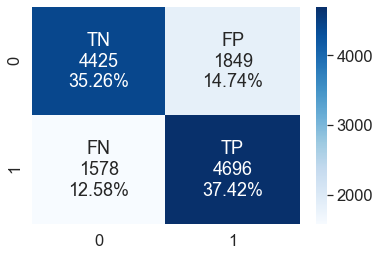

In [92]:
# Train:
train_eval(clf_LR_sm, X_train_sm, y_train_sm, 'Logistic Regression', 'smote')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.94      0.73      0.82      3090
           1       0.36      0.76      0.49       626

    accuracy                           0.73      3716
   macro avg       0.65      0.74      0.65      3716
weighted avg       0.84      0.73      0.76      3716
 

AUC-ROC
0.8091599718767125 

Confusion Matrix


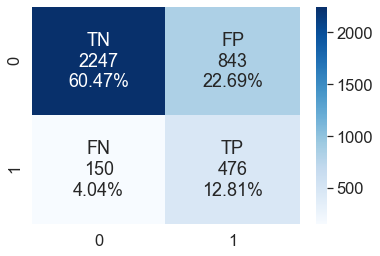

In [93]:
#Test:
test_eval(clf_LR_sm, X_test_scaled, y_test, 'Logistic Regression', 'smote')

In [94]:
y_pred = clf_LR_sm.predict(X_train_sm)
Accuracy_Train =  accuracy_score(y_train_sm, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_LR_sm.predict(X_test_scaled)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)


Accuracy_Train 0.7268887472107108
Accuracy_Test 0.7327771797631862


### Model-2: Naïve Bayes - SMOTE Resampling

In [95]:
# copy of datasets
X_train_sm = X_train_smote.copy()
y_train_sm = y_train_smote.copy()

In [96]:
clf_nb.fit(X_train_sm, y_train_sm)

GaussianNB()

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.73      0.54      0.62      6274
           1       0.63      0.80      0.71      6274

    accuracy                           0.67     12548
   macro avg       0.68      0.67      0.66     12548
weighted avg       0.68      0.67      0.66     12548
 

AUC-ROC
0.7784171770519154 

Confusion Matrix


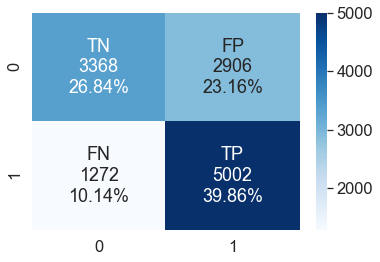

In [97]:
# Train:
train_eval(clf_nb, X_train_sm, y_train_sm, 'Naive Bayes', 'smote')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.93      0.57      0.70      3090
           1       0.27      0.79      0.40       626

    accuracy                           0.60      3716
   macro avg       0.60      0.68      0.55      3716
weighted avg       0.82      0.60      0.65      3716
 

AUC-ROC
0.7865605322745742 

Confusion Matrix


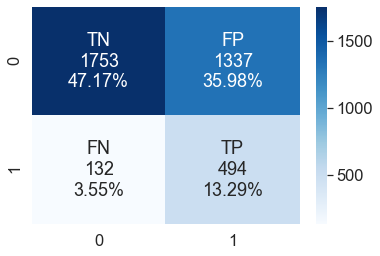

In [98]:
#Test:
test_eval(clf_nb, X_test_scaled, y_test, 'Naive Bayes', 'smote')

In [99]:
y_pred = clf_nb.predict(X_train_sm)
Accuracy_Train =  accuracy_score(y_train_sm, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_nb.predict(X_test_scaled)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)

Accuracy_Train 0.6670385718839655
Accuracy_Test 0.6046824542518837


### Model-3: Stochastic Gradient Descent - SMOTE Resampling

In [100]:
# copy of datasets
X_train_sm = X_train_smote.copy()
y_train_sm = y_train_smote.copy()

In [101]:
clf_sgd.fit(X_train_sm, y_train_sm)

SGDClassifier(loss='log', max_iter=1500, random_state=123)

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.77      0.57      0.65      6274
           1       0.66      0.83      0.73      6274

    accuracy                           0.70     12548
   macro avg       0.71      0.70      0.69     12548
weighted avg       0.71      0.70      0.69     12548
 

AUC-ROC
0.7954314469733005 

Confusion Matrix


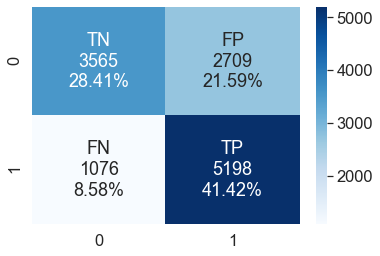

In [102]:
#Train:
train_eval(clf_sgd, X_train_sm, y_train_sm, 'Stochastic Gradient Descent', 'smote')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.95      0.60      0.73      3090
           1       0.30      0.85      0.44       626

    accuracy                           0.64      3716
   macro avg       0.62      0.72      0.59      3716
weighted avg       0.84      0.64      0.68      3716
 

AUC-ROC
0.8079125179647839 

Confusion Matrix


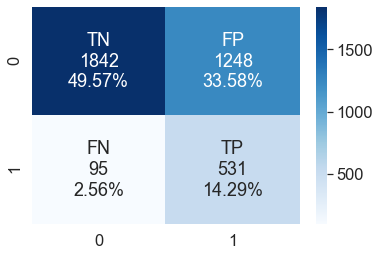

In [103]:
#Test:
test_eval(clf_sgd, X_test_scaled, y_test, 'Stochastic Gradient Descent', 'smote')

In [104]:
y_pred = clf_sgd.predict(X_train_sm)
Accuracy_Train =  accuracy_score(y_train_sm, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_sgd.predict(X_test_scaled)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)

Accuracy_Train 0.6983583041122091
Accuracy_Test 0.6385898815931109


### Model-4: K-Nearest Neighbours - SMOTE Resampling

In [105]:
# copy of datasets
X_train_sm = X_train_smote.copy()
y_train_sm = y_train_smote.copy()

In [106]:
clf_knn.fit(X_train_sm, y_train_sm)

KNeighborsClassifier()

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.96      0.89      0.93      6274
           1       0.90      0.96      0.93      6274

    accuracy                           0.93     12548
   macro avg       0.93      0.93      0.93     12548
weighted avg       0.93      0.93      0.93     12548
 

AUC-ROC
0.9856986786296884 

Confusion Matrix


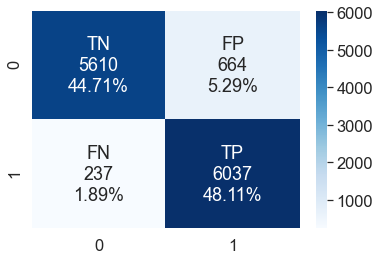

In [107]:
#Train:
train_eval(clf_knn, X_train_sm, y_train_sm, 'K-Nearest Neighbours', 'smote')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      3090
           1       0.49      0.76      0.59       626

    accuracy                           0.82      3716
   macro avg       0.72      0.80      0.74      3716
weighted avg       0.87      0.82      0.84      3716
 

AUC-ROC
0.8700424951146126 

Confusion Matrix


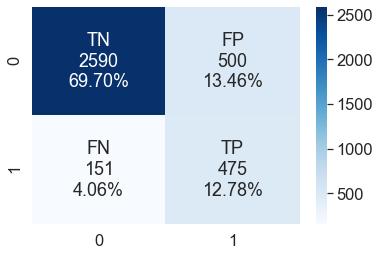

In [108]:
#Test:
test_eval(clf_knn, X_test_scaled, y_test, 'K-Nearest Neighbours', 'smote')

In [109]:
y_pred = clf_knn.predict(X_train_sm)
Accuracy_Train =  accuracy_score(y_train_sm, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_knn.predict(X_test_scaled)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)

Accuracy_Train 0.9281957284029327
Accuracy_Test 0.8248116254036598


### Model-5: Decision Tree - SMOTE Resampling

In [110]:
# copy of datasets
X_train_sm = X_train_smote.copy()
y_train_sm = y_train_smote.copy()

In [111]:
clf_DT.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier(max_depth=15, max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=10)

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      6274
           1       0.85      0.88      0.87      6274

    accuracy                           0.86     12548
   macro avg       0.86      0.86      0.86     12548
weighted avg       0.86      0.86      0.86     12548
 

AUC-ROC
0.9484361562597394 

Confusion Matrix


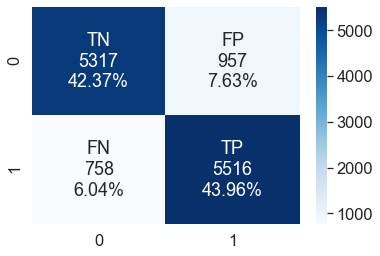

In [112]:
#Train:
train_eval(clf_DT, X_train_sm, y_train_sm, 'Decision Tree', 'smote')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      3090
           1       0.42      0.66      0.51       626

    accuracy                           0.79      3716
   macro avg       0.67      0.74      0.69      3716
weighted avg       0.84      0.79      0.81      3716
 

AUC-ROC
0.8230897877312158 

Confusion Matrix


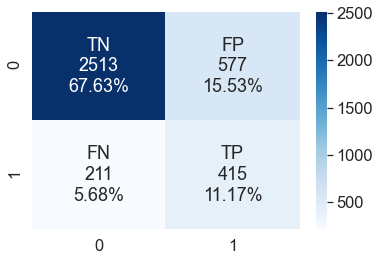

In [113]:
#Test:
test_eval(clf_DT, X_test_scaled, y_test, 'Decision Tree', 'smote')

In [114]:
y_pred = clf_DT.predict(X_train_sm)
Accuracy_Train =  accuracy_score(y_train_sm, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_DT.predict(X_test_scaled)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)

Accuracy_Train 0.8633248326426523
Accuracy_Test 0.7879440258342304


### Model-6: Random Forest - SMOTE Resampling

In [115]:
# copy of datasets
X_train_sm = X_train_smote.copy()
y_train_sm = y_train_smote.copy()

In [116]:
clf_RF.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_depth=23, max_features='log2', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=500)

Classification Report for Train dataset
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      6274
           1       0.93      0.96      0.94      6274

    accuracy                           0.94     12548
   macro avg       0.94      0.94      0.94     12548
weighted avg       0.94      0.94      0.94     12548
 

AUC-ROC
0.989869935469474 

Confusion Matrix


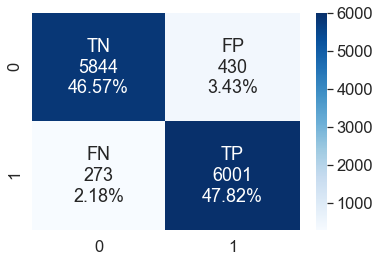

In [117]:
#Train:
train_eval(clf_RF, X_train_sm, y_train_sm, 'Random Forest', 'smote')

Classification Report for Test dataset
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      3090
           1       0.59      0.71      0.65       626

    accuracy                           0.87      3716
   macro avg       0.76      0.81      0.78      3716
weighted avg       0.88      0.87      0.87      3716
 

AUC-ROC
0.9024507067009937 

Confusion Matrix


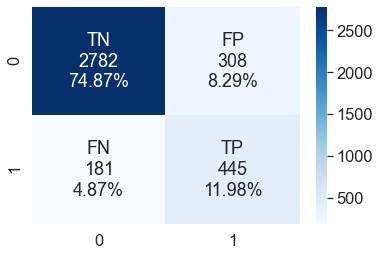

In [118]:
#Test:
test_eval(clf_RF, X_test_scaled, y_test, 'Random Forest', 'smote')

In [119]:
y_pred = clf_RF.predict(X_train_sm)
Accuracy_Train =  accuracy_score(y_train_sm, y_pred)
print ('Accuracy_Train', Accuracy_Train)

y_pred = clf_RF.predict(X_test_scaled)
Accuracy_Test =  accuracy_score(y_test, y_pred)
print ('Accuracy_Test', Accuracy_Test)


Accuracy_Train 0.9439751354797578
Accuracy_Test 0.8684068891280947


### Model Comparision for balanced data

In [120]:
clf_eval_df2 = pd.DataFrame({'Model':model,
                            'Dataset':dataset,
                            'Resample':resample,
                            'Precision':precision,
                            'Recall':recall,
                            'f1-score':F1score,
                            'Accuracy':Accuracy,
                            'AUC-ROC':AUCROC})

In [121]:
cm = sns.light_palette("green", as_cmap = True)
s = clf_eval_df2.style.background_gradient(cmap=cm)
s

,Model,Dataset,Resample,Precision,Recall,f1-score,Accuracy,AUC-ROC
0,Logistic Regression,train,smote,0.717494,0.748486,0.732662,0.726889,0.797013
1,Logistic Regression,test,smote,0.360879,0.760383,0.489460,0.732777,0.809160
2,Naive Bayes,train,smote,0.632524,0.797259,0.705401,0.667039,0.778417
3,Naive Bayes,test,smote,0.269798,0.789137,0.402116,0.604682,0.786561
4,Stochastic Gradient Descent,train,smote,0.657392,0.828499,0.733094,0.698358,0.795431
5,Stochastic Gradient Descent,test,smote,0.298482,0.848243,0.441580,0.638590,0.807913
6,K-Nearest Neighbours,train,smote,0.900910,0.962225,0.930559,0.928196,0.985699
7,K-Nearest Neighbours,test,smote,0.487179,0.758786,0.593379,0.824812,0.870042
8,Decision Tree,train,smote,0.852155,0.879184,0.865459,0.863325,0.948436
9,Decision Tree,test,smote,0.418347,0.662939,0.512979,0.787944,0.823090
